# Customer churn analysis


# Machine Learning Pipeline

In the following notebooks, we will go through the implementation of each one of the steps in the Machine Learning Pipeline. 

We will discuss:

1. Data Preparation and Analysis
2. Feature Engineering
3. Feature Selection
4. Model Training
5. Obtaining Predictions / Scoring

In [1]:
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.types import *
import pandas as pd
import matplotlib.pyplot as plt
from snowflake.snowpark.functions import udf
%matplotlib inline
import datetime as dt
import numpy as np
import seaborn as sns
import json

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline

# setup pipeline

#transformations
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer

#Classifier
from sklearn.ensemble import RandomForestClassifier

#Pipeline
from sklearn.pipeline import make_pipeline

#Model Accuracy
from sklearn.metrics import balanced_accuracy_score

# to save the trained scaler class
import joblib

In [2]:
#Snowflake connection info
from config import snowflake_conn_prop
from snowflake.snowpark import version
print(version.VERSION)

# connect to Snowflake
with open("secrets.json", "r") as f:
    snowflake_conn_prop = json.load(f)  
session = Session.builder.configs(snowflake_conn_prop).create()
print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())

(1, 11, 1)
[Row(CURRENT_WAREHOUSE()='SNOWPARK_WH', CURRENT_DATABASE()='CHURN_DB', CURRENT_SCHEMA()='CHURN_SCHEMA')]


In [3]:
%%time
raw = session.table('TELCO_TRAIN_SET_BIN')
df_churn = raw.toPandas()

CPU times: user 692 ms, sys: 48.6 ms, total: 741 ms
Wall time: 1.16 s


In [4]:
df_churn.head(10)

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,...,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,TENUREMONTHSBIN,MONTHLYCHARGESBIN,TOTALCHARGESBIN,TENUREMONTHS,MONTHLYCHARGES,TOTALCHARGES,CHURNVALUE
0,Female,No,No,Yes,Yes,No,Fiber optic,No,No,No,...,Month-to-month,Yes,Electronic check,Low,Low,Low,2,70.70,151.65,1
1,Female,No,No,Yes,Yes,Yes,Fiber optic,No,No,Yes,...,Month-to-month,Yes,Electronic check,Medium,Medium,Low,8,99.65,820.50,1
2,Male,Yes,No,Yes,Yes,Yes,Fiber optic,No,No,No,...,Month-to-month,Yes,Electronic check,Low,Medium,Low,18,95.45,1752.55,1
3,Male,No,No,Yes,Yes,Yes,Fiber optic,No,No,No,...,Month-to-month,Yes,Electronic check,Medium,Low,Low,3,74.40,229.55,1
4,Female,No,No,Yes,Yes,No,Fiber optic,No,Yes,Yes,...,Month-to-month,Yes,Electronic check,Low,Medium,Low,13,79.25,1111.65,1
5,Male,No,No,Yes,Yes,No,Fiber optic,Yes,No,No,...,Month-to-month,Yes,Mailed check,Low,High,Low,1,84.60,84.60,1
6,Male,No,No,No,Yes,No,No,No internet service,No internet service,No internet service,...,Two year,No,Mailed check,Low,High,Low,59,19.35,1099.60,1
7,Male,Yes,No,No,Yes,No,Fiber optic,No,Yes,No,...,Month-to-month,Yes,Electronic check,Low,Low,Low,8,74.50,606.55,1
8,Male,No,No,No,Yes,No,Fiber optic,No,No,No,...,Month-to-month,Yes,Electronic check,Medium,High,Medium,5,80.60,415.55,1
9,Male,Yes,Yes,No,Yes,No,Fiber optic,No,No,Yes,...,Month-to-month,Yes,Electronic check,High,Medium,Medium,24,93.15,2231.05,1


In [5]:
df_churn.shape

(112040, 23)

# Separate dataset into train and test

It is important to separate our data intro training and testing set. 

When we engineer features, some techniques learn parameters from data. It is important to learn these parameters only from the train set. This is to avoid over-fitting.

In [6]:
# Let's separate into train and test set
# Remember to set the seed (random_state for this sklearn function)

# to divide train and test set
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(
    #data.drop(columns=['CHURNVALUE','CUSTOMERID'], axis=1), # predictive variables
    #data.drop(columns=['CHURNVALUE'], axis=1), # predictive variables
    #data['CHURNVALUE'], # target
    #test_size=0.2, # portion of dataset to allocate to test set
    #random_state=0, # we are setting the seed here
#)

#X_train.shape, X_test.shape


In [7]:
# seed value
SEED = 42
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)

for train_index, test_index in strat_split.split(df_churn, df_churn["CHURNVALUE"]):
    strat_train_set = df_churn.loc[train_index]
    strat_test_set = df_churn.loc[test_index]

print('Target Labels Ratio in Original Dataset\n')
print(df_churn["CHURNVALUE"].value_counts(normalize=True).sort_index())
# df_churn_cleaned["Churn"].value_counts() / len(strat_test_set)

print('\nTarget Labels Ratio in Test Dataset\n')
print(strat_test_set["CHURNVALUE"].value_counts(normalize=True).sort_index())
# strat_test_set["Churn"].value_counts() / len(strat_test_set)

Target Labels Ratio in Original Dataset

CHURNVALUE
0    0.677624
1    0.322376
Name: proportion, dtype: float64

Target Labels Ratio in Test Dataset

CHURNVALUE
0    0.677615
1    0.322385
Name: proportion, dtype: float64


In [8]:
strat_train_set.shape

(89632, 23)

In [9]:
strat_test_set.shape

(22408, 23)

In [10]:
strat_train_set.head()

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,...,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,TENUREMONTHSBIN,MONTHLYCHARGESBIN,TOTALCHARGESBIN,TENUREMONTHS,MONTHLYCHARGES,TOTALCHARGES,CHURNVALUE
64821,Male,No,Yes,No,Yes,Yes,Fiber optic,No,No,No,...,Month-to-month,Yes,Credit card (automatic),High,Medium,Low,30,94.05,2866.45,1
86812,Female,No,No,No,Yes,Yes,Fiber optic,No,No,No,...,Month-to-month,Yes,Electronic check,High,Medium,Low,7,75.35,564.65,0
72644,Male,No,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,...,Two year,Yes,Bank transfer (automatic),High,Medium,Low,24,24.10,587.40,0
31386,Male,Yes,Yes,No,Yes,Yes,DSL,Yes,Yes,Yes,...,One year,Yes,Credit card (automatic),Medium,Low,Low,67,69.35,4653.25,0
19479,Female,No,Yes,Yes,Yes,Yes,Fiber optic,No,No,No,...,Month-to-month,No,Electronic check,Low,Medium,Low,10,85.95,858.60,0


In [11]:
strat_test_set.head()

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,...,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,TENUREMONTHSBIN,MONTHLYCHARGESBIN,TOTALCHARGESBIN,TENUREMONTHS,MONTHLYCHARGES,TOTALCHARGES,CHURNVALUE
14070,Male,No,Yes,No,Yes,No,DSL,Yes,Yes,No,...,One year,Yes,Mailed check,High,Medium,High,16,55.85,857.80,0
32458,Female,No,No,No,Yes,No,Fiber optic,Yes,No,Yes,...,Month-to-month,No,Electronic check,Low,Low,Low,31,87.60,2724.25,0
97738,Female,No,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,...,Two year,Yes,Mailed check,Medium,High,Medium,58,19.85,1158.85,0
9892,Female,No,No,No,Yes,No,DSL,No,No,No,...,Month-to-month,Yes,Electronic check,Low,Low,High,3,55.30,196.15,1
110280,Male,No,No,No,Yes,No,DSL,No,No,No,...,Month-to-month,No,Mailed check,Low,Medium,Low,1,46.30,46.30,1


In [12]:
final_cols = strat_train_set.columns
print(final_cols)

Index(['GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS', 'PHONESERVICE',
       'MULTIPLELINES', 'INTERNETSERVICE', 'ONLINESECURITY', 'ONLINEBACKUP',
       'DEVICEPROTECTION', 'TECHSUPPORT', 'STREAMINGTV', 'STREAMINGMOVIES',
       'CONTRACT', 'PAPERLESSBILLING', 'PAYMENTMETHOD', 'TENUREMONTHSBIN',
       'MONTHLYCHARGESBIN', 'TOTALCHARGESBIN', 'TENUREMONTHS',
       'MONTHLYCHARGES', 'TOTALCHARGES', 'CHURNVALUE'],
      dtype='object')


In [13]:
%%time
session.write_pandas(strat_train_set[final_cols], 'CHURN_TRAIN_DATASET_BIN', auto_create_table=True, overwrite =True )

/Applications/opt/anaconda3/envs/snowpark-39/lib/python3.9/site-packages/snowflake/snowpark/session.py:1951: UserWarning: Pandas Dataframe has non-standard index of type <class 'pandas.core.indexes.base.Index'> which will not be written. Consider changing the index to pd.RangeIndex(start=0,...,step=1) or call reset_index() to keep index as column(s)
  success, nchunks, nrows, ci_output = write_pandas(


CPU times: user 316 ms, sys: 35.9 ms, total: 352 ms
Wall time: 7.27 s


In [14]:
%%time
session.write_pandas(strat_test_set[final_cols], 'CHURN_TEST_DATASET_BIN', auto_create_table=True, overwrite=True)

CPU times: user 87.1 ms, sys: 10.9 ms, total: 98 ms
Wall time: 3.45 s


In [15]:

# train Dataset
X_train = strat_train_set.drop("CHURNVALUE", axis=1)
y_train = strat_train_set["CHURNVALUE"].copy()

# test dataset
y_test = strat_test_set['CHURNVALUE'].values
X_test = strat_test_set.drop('CHURNVALUE',axis=1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((89632, 22), (89632,), (22408, 22), (22408,))

In [16]:
X_train.head()

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,...,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,TENUREMONTHSBIN,MONTHLYCHARGESBIN,TOTALCHARGESBIN,TENUREMONTHS,MONTHLYCHARGES,TOTALCHARGES
64821,Male,No,Yes,No,Yes,Yes,Fiber optic,No,No,No,...,Yes,Month-to-month,Yes,Credit card (automatic),High,Medium,Low,30,94.05,2866.45
86812,Female,No,No,No,Yes,Yes,Fiber optic,No,No,No,...,No,Month-to-month,Yes,Electronic check,High,Medium,Low,7,75.35,564.65
72644,Male,No,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,...,No internet service,Two year,Yes,Bank transfer (automatic),High,Medium,Low,24,24.10,587.40
31386,Male,Yes,Yes,No,Yes,Yes,DSL,Yes,Yes,Yes,...,No,One year,Yes,Credit card (automatic),Medium,Low,Low,67,69.35,4653.25
19479,Female,No,Yes,Yes,Yes,Yes,Fiber optic,No,No,No,...,Yes,Month-to-month,No,Electronic check,Low,Medium,Low,10,85.95,858.60


In [17]:
y_train.head()

64821    1
86812    0
72644    0
31386    0
19479    0
Name: CHURNVALUE, dtype: int8

## let's identify the different variables

In [18]:
# Since we already cleaned up the data using snowpark, identifying variable is super easy

# we will capture those of type *object*

cat_vars = ['GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS', 'PHONESERVICE', 'MULTIPLELINES', 'INTERNETSERVICE',
            'ONLINESECURITY', 'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT', 'STREAMINGTV', 'STREAMINGMOVIES',
            'CONTRACT', 'PAPERLESSBILLING', 'PAYMENTMETHOD', 'TENUREMONTHSBIN', 'MONTHLYCHARGESBIN', 'TOTALCHARGESBIN']

# we will capture those of type numerical from previous notebook
num_vars = ['TENUREMONTHS', 'MONTHLYCHARGES', 'TOTALCHARGES']

features = cat_vars + num_vars
print(features)

['GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS', 'PHONESERVICE', 'MULTIPLELINES', 'INTERNETSERVICE', 'ONLINESECURITY', 'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT', 'STREAMINGTV', 'STREAMINGMOVIES', 'CONTRACT', 'PAPERLESSBILLING', 'PAYMENTMETHOD', 'TENUREMONTHSBIN', 'MONTHLYCHARGESBIN', 'TOTALCHARGESBIN', 'TENUREMONTHS', 'MONTHLYCHARGES', 'TOTALCHARGES']


## Numerical variable transformation

In the previous notebook, we observed that the numerical variables are not normally distributed.

We will transform with the MinMaxScaler in order to get a more Gaussian-like distribution. Use ordinal encoding for the categorical variables and check for nulls


In [19]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

# check absence of na in the test set
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

In [20]:
# Model Pipeline
ord_pipe = make_pipeline(
    FunctionTransformer(lambda x: x.astype(str)) ,
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    )

num_pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0),
    MinMaxScaler()
    )

clf = make_pipeline(RandomForestClassifier(random_state=0, n_jobs=-1))

model = make_pipeline(ord_pipe, num_pipe, clf)

# fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('pipeline-1',
                 Pipeline(steps=[('functiontransformer',
                                  FunctionTransformer(func=<function <lambda> at 0x7fe2422ba9d0>)),
                                 ('ordinalencoder',
                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                 unknown_value=-1))])),
                ('pipeline-2',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(fill_value=0,
                                                strategy='constant')),
                                 ('minmaxscaler', MinMaxScaler())])),
                ('pipeline-3',
                 Pipeline(steps=[('randomforestclassifier',
                                  RandomForestClassifier(n_jobs=-1,
                                                         random_state=0))]))])

## Check Accuracy of our model on test dataset

In [21]:
y_pred = model.predict_proba(X_test)[:,1]
predictions = [round(value) for value in y_pred]
balanced_accuracy = balanced_accuracy_score(y_test, predictions)
print("Model testing completed.\n   - Model Balanced Accuracy: %.2f%%" % (balanced_accuracy * 100.0))

Model testing completed.
   - Model Balanced Accuracy: 98.50%


## Confusion Matrix

True Positive(TP)  =  7067
False Positive(FP) =  126
True Negative(TN)  =  15058
False Negative(FN) =  157
Accuracy of the classification = 0.987


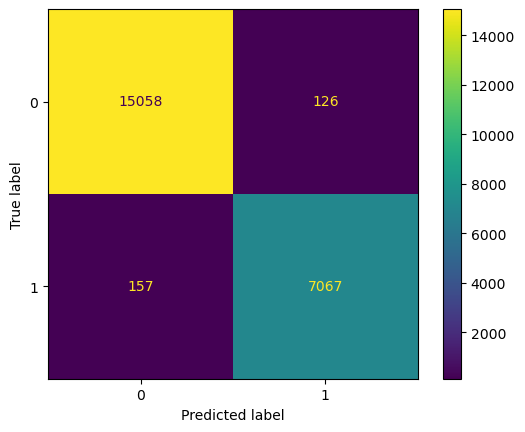

In [22]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=clf.classes_)
disp.plot()

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP+TN) /(TP+FP+TN+FN)

print('Accuracy of the classification = {:0.3f}'.format(accuracy))

## Check for important features

Text(0.5, 0, 'Feature Importance')

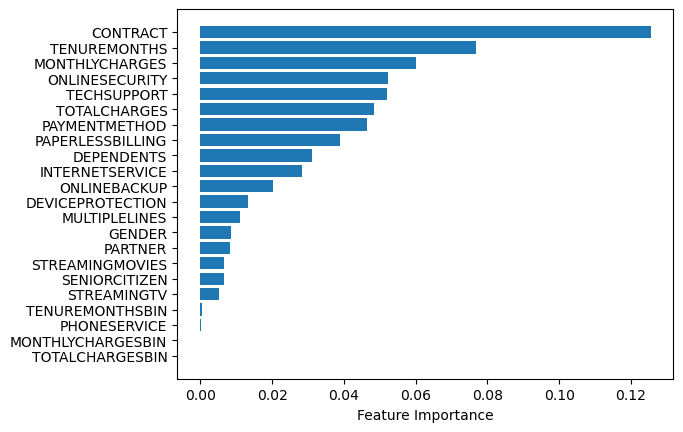

In [23]:
# Feature importance
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(np.array(X_test.columns)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Feature Importance")

## Prepare for model deployment in Snowflake using Snowpark Python UDF

In [24]:
#Let's first create a stage to store the artifacts
print(session.sql('create stage if not exists MODELSTAGE').collect())

[Row(status='MODELSTAGE already exists, statement succeeded.')]


### We will define a snowpark python UDF to help us score the live data using the model that we built earlier. 

Since we have fitted the model with the scikit learn pipeline, our UDF will do the transformations and also score the new data

In [25]:
features = list(X_train.columns)

session.add_packages("scikit-learn==1.0.2", "pandas", "numpy")

@udf(name='predict_churn_bin',is_permanent = True, stage_location = '@MODELSTAGE', replace=True)
def predict_churn(args: list) -> float:
    row = pd.DataFrame([args], columns=features)
    return model.predict(row)



The version of package 'numpy' in the local environment is 1.26.3, which does not fit the criteria for the requirement 'numpy'. Your UDF might not work when the package version is different between the server and your local environment.


In [26]:
new_df = session.table('TRAIN_DATASET_BIN').sample(n = 1000)

In [27]:
new_df.show(10)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMERID"  |"GENDER"  |"SENIORCITIZEN"  |"PARTNER"  |"DEPENDENTS"  |"TENUREMONTHS"  |"PHONESERVICE"  |"MULTIPLELINES"   |"INTERNETSERVICE"  |"ONLINESECURITY"     |"ONLINEBACKUP"       |"DEVICEPROTECTION"   |"TECHSUPPORT"        |"STREAMINGTV"        |"STREAMINGMOVIES"    |"CONTRACT"      |"PAPERLESSBILLING"  |"PAYMENTMETHOD"            |"MONTHLYCHARGES"  |"TOTALCHARGES"  |"TENUREMONTHSBIN"  |"MONTHLYCHARGESBIN"  |"TOTALCHARGESBIN"  |"CHURNVALUE"  |
--------------------------------------------------------------------------------------

In [28]:
%%time
new_df.select(new_df.CUSTOMERID,new_df.CHURNVALUE, \
              F.call_udf("predict_churn_bin", F.array_construct(*features)).alias('PREDICTED_CHURN_BIN')) \
        .write.mode('overwrite').saveAsTable('churn_detection_bin')


CPU times: user 27.3 ms, sys: 2.84 ms, total: 30.1 ms
Wall time: 29.1 s


In [29]:
session.table('churn_detection_bin').toPandas()

,CUSTOMERID,CHURNVALUE,PREDICTED_CHURN_BIN
0,21fXYlEuqB,0,0.0
1,sNiV6aPaoN,0,0.0
2,EwPZTGKa9I,0,0.0
3,K8ZVdzdWBF,1,1.0
4,StKpwMIFhI,0,0.0
...,...,...,...
995,QDu0UH0TTD,1,1.0
996,2aK4qQK977,1,1.0
997,6F81hmxOVZ,0,0.0
998,6zzm4vvA2x,0,0.0


## Different Syntax to register the prediction UDF for deployment

In [30]:
%%time
session.add_packages("scikit-learn==1.0.2", "pandas", "numpy")
features = list(X_train.columns)
predict_churn_model = session.udf.register(lambda *args: 
                                    model.predict(pd.DataFrame(args, columns=features)),
                                    name="predict_churn_bin_model",
                                    stage_location="@MODELSTAGE",
                                    return_type=FloatType(),
                                    is_permanent=True,
                                    replace=True,
                                    input_types=[ArrayType()])

The version of package 'numpy' in the local environment is 1.26.3, which does not fit the criteria for the requirement 'numpy'. Your UDF might not work when the package version is different between the server and your local environment.


CPU times: user 1.99 s, sys: 114 ms, total: 2.1 s
Wall time: 14.1 s


## if we want to do the prediction using SQL

In [31]:
%%time
session.sql(' select customerid,churnvalue, \
            predict_churn_bin(ARRAY_CONSTRUCT( \
                                    GENDER, \
                                    SENIORCITIZEN, \
                                    PARTNER, \
                                    DEPENDENTS, \
                                    PHONESERVICE, \
                                    MULTIPLELINES,  \
                                    INTERNETSERVICE,  \
                                    ONLINESECURITY,  \
                                    ONLINEBACKUP, \
                                    DEVICEPROTECTION,  \
                                    TECHSUPPORT,  \
                                    STREAMINGTV,  \
                                    STREAMINGMOVIES, \
                                    CONTRACT,  \
                                    PAPERLESSBILLING,  \
                                    PAYMENTMETHOD, \
                                    TENUREMONTHS, \
                                    MONTHLYCHARGES,  \
                                    TOTALCHARGES, \
                                    TENUREMONTHSBIN, \
                                    MONTHLYCHARGESBIN,  \
                                    TOTALCHARGESBIN)) as Churn_prediction_bin \
                                    from train_dataset_bin sample (10 rows)').show()

--------------------------------------------------------
|"CUSTOMERID"  |"CHURNVALUE"  |"CHURN_PREDICTION_BIN"  |
--------------------------------------------------------
|mJgrTLnmWd    |0             |0.0                     |
|9EFvKVbQk0    |1             |0.0                     |
|A8fKMJD6GU    |0             |0.0                     |
|EhZf034EtN    |1             |1.0                     |
|fzbAVXp4U9    |1             |1.0                     |
|iULbaFvm3T    |0             |1.0                     |
|IyuCeXoU8o    |0             |0.0                     |
|7ciONLDCC5    |1             |1.0                     |
|9BIdear6TJ    |1             |1.0                     |
|kBLkfI2yGi    |1             |1.0                     |
--------------------------------------------------------

CPU times: user 9.38 ms, sys: 1.86 ms, total: 11.2 ms
Wall time: 6.18 s


In [32]:
session.close()